Ricky found that for some points the disagreement is very large between
the covmat calculation and the mcvine simulation.
Here we want to see why.

Check some simple cases where we can estimate the correlation

In [1]:
workdir = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/7-check-bad-points-1/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/7-check-bad-points-1


In [2]:
!which mcvine

/SNS/software/miniconda2/envs/mcvine-unstable/bin/mcvine


# Tools

In [3]:
import mcvine.cli
from mcvine_workflow.singlextal.resolution import use_covmat, use_res_comps
import numpy as np
import histogram as H, histogram.hdf as hh

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

# Sample

In [4]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
 - type: DGSresolution
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: block width="2*inch" height="4.*inch" thickness="1*mm"
temperature: 100*K

Writing Si.yml


In [5]:
sampleyml = "Si.yml"

# Instrument

In [6]:
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "13.6*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )

# Experiment

In [7]:
Ei = 126
class dynamics:
    hkl0 = [-8.21,-0,0]
    hkl_dir = np.array([1.,0.,0.])
    E = 7.8
    dq = 0
class scan:
    min, max, step = -5, 90., 0.5

In [8]:
from mcni.utils import conversion as Conv

# Use Cov Mat

In [38]:
def compute(
        sample_yml, Ei, dynamics, psi_scan, instrument, pixel, tofwidths, beamdivs, samplethickness,
        plot=False):
    print "XXXXXXXXXXXXXXXXXXXXXXX"
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # should P be the T0 chopper?
    L_PM=mcvine.units.parse(instrument.L_m2fc)/mcvine.units.meter # P chopper to M chopper distance
    L_PS= mcvine.units.parse(instrument.L_m2s)/mcvine.units.meter  # P chopper to sample
    L_MS=L_PS-L_PM
    #
    R = mcvine.units.parse(instrument.detsys_radius)/mcvine.units.meter # 

    hkl0 = dynamics.hkl0
    hkl_dir = dynamics.hkl_dir # projection
    psimin = psi_scan.min
    psimax = psi_scan.max
    dpsi = psi_scan.step

    # dynamics calculations
    E = dynamics.E
    dq = dynamics.dq
    hkl = hkl0 + dq*hkl_dir

    from mcni.utils import conversion as Conv
    vi = Conv.e2v(Ei)

    ti = L_PM/vi*1e6 # microsecond
    Ef = Ei - E
    vf = Conv.e2v(Ef)

    # find the psi angle
    from mcvine_workflow.singlextal.io import loadXtalOriFromSampleYml
    xtalori = loadXtalOriFromSampleYml(sample_yml)
    from mcvine_workflow.singlextal.solve_psi import solve
    print Ei, hkl, E, psimin, psimax
    results = solve(
        xtalori, Ei, hkl, E, psimin, psimax,
        Nsegments = 10)
#        Nsegments = 100)
    from mcvine_workflow.singlextal.coords_transform import hkl2Q
    for r in results:
        xtalori.psi = r*np.pi/180
        print "psi=%s, Q=%s" % (r, hkl2Q(hkl, xtalori))
        print "hkl2Q=%r\n(Q = hkl dot hkl2Q)" % (xtalori.hkl2cartesian_mat(),)
    # these are the psi angles that the particular point of interest will be measured
    # print results
    assert len(results)
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # only select the first one. this is OK for most cases but there are cases where more than
    # one psi angles satisfy the condition
    psi = results[0]
    print "psi=%s degree" % psi
    xtalori.psi = psi*np.pi/180
    print "psi=%s radian" % xtalori.psi
    Q = hkl2Q(hkl, xtalori)
    hkl2Q_mat = xtalori.hkl2cartesian_mat()
    # print Q
    # print hkl2Q_mat
    #
    Q_len = np.linalg.norm(Q); print Q_len
    ki = Conv.e2k(Ei); print ki
    kiv = np.array([ki, 0, 0])
    kfv = kiv - Q; print kfv
    #
    # ** Verify the momentum and energy transfers **
    # print Ei-Conv.k2e(np.linalg.norm(kfv))
    # print Ei-Ef
    assert np.isclose(Ei-Ef, E)

    # ** Compute detector pixel position **
    z = kfv[2]/(kfv[0]**2+kfv[1]**2)**.5 * R
    L_SD=(z**2+R**2)**.5
    # print z, L_SD

    # ### Constants
    eV = 1.60218e-19
    meV = eV*1e-3
    mus = 1.e-6
    hbar= 1.0545718e-34
    AA = 1e-10
    m = 1.6750e-24 * 1e-3 #kg
    from numpy import sin, cos

    # dE calcuation starts here
    # ## Differentials
    pE_pt = -m*(vi**3/L_PM + vf**3/L_SD * L_MS/L_PM)
    # convert to eV/microsecond
    pE_pt /= meV/mus
    # print pE_pt

    pE_ptMD = m*vf**3/L_SD
    pE_ptMD /= meV/mus
    # print pE_ptMD

    pE_pLPM = m/L_PM * (vi**2 + vf**3/vi * L_MS/ L_SD)
    pE_pLPM /= meV
    # print pE_pLPM

    pE_pLMS= -m/L_SD * (vf**3/vi)
    pE_pLMS /= meV
    # print pE_pLMS

    pE_pLSD = -m*vf*vf/L_SD
    pE_pLSD /= meV
    # print pE_pLSD

    # we don't need pE_pLSD, instead we need pE_pR and pE_pz. R and z are cylinder radius and z coordinate
    pE_pR = pE_pLSD * (R/L_SD)
    pE_pz = pE_pLSD * (z/L_SD)
    # print pE_pR, pE_pz

    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    # ## ** Paramters: Estimate of standard deviations
    # tau_P = 10 # microsecond
    # tau_M = 8 # microsecond
    tau_P = tofwidths.P
    tau_M = tofwidths.M
    #
    # tau_D = 10 # microsecond
    tau_D = mcvine.units.parse(pixel.radius)/mcvine.units.meter*2/vf*1e6 # microsecond

    # ## Calculations
    pE_p_vec = [pE_pt, pE_ptMD, pE_pLPM, pE_pLMS, pE_pR, pE_pz]
    pE_p_vec = np.array(pE_p_vec)
    J_E = pE_p_vec/E

    # print J_E
    sigma_t = (tau_P**2+tau_M**2)**.5
    sigma_tMD = (tau_M**2+tau_D**2)**.5
    # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    div = (beamdivs.theta**2 + beamdivs.phi**2)**.5  # a crude approx
    sigma_LPM = L_PM * div*div

    # mainly due to sample size
    sigma_LMS = samplethickness

    # mainly due to det tube diameter
    sigma_R = mcvine.units.parse(pixel.radius)/mcvine.units.meter*2

    # pixel size
    sigma_z = mcvine.units.parse(pixel.height)/mcvine.units.meter

    sigma = np.array([sigma_t, sigma_tMD, sigma_LPM, sigma_LMS, sigma_R, sigma_z])
    # print sigma
    sigma2 = sigma*sigma
    # print sigma2
    sigma2 = np.diag(sigma2)

    # print J_E
    # print np.dot(sigma2, J_E)
    cov = np.dot(J_E, np.dot(sigma2, J_E))

    # print cov, np.sqrt(cov)
    sigma_E = E*np.sqrt(cov)
    # print sigma_E

    # Not sure if this is right:
    # 
    # * ** Note: this may be more like FWHM than sigma_E because of the approx I made **
    # * ** FWHM is 2.355 sigma **

    # ## Include Q
    print "ti=",ti
    tf = L_SD/vf*1e6; print "tf=",tf
    thetai = 0
    phii = 0
    print "R=", R
    print "Q=", Q

    eeta = np.arctan2(kfv[1], kfv[0])
    print "eeta=", eeta

    pQx_pt = -m/hbar*(L_PM/ti/ti/mus/mus*cos(thetai)*cos(phii)
                      +R/tf/tf/mus/mus*L_MS/L_PM*cos(eeta))
    pQx_pt/=1./AA/mus
    # print pQx_pt

    pQx_ptMD = m/hbar * R/tf/tf * cos(eeta) / mus/mus
    pQx_ptMD /= 1./AA/mus
    # print pQx_ptMD

    pQx_pLPM = m/hbar *(cos(thetai) * cos(phii)/ti + ti/tf/tf * R*L_MS/L_PM/L_PM * cos(eeta)) / mus
    pQx_pLPM /= 1./AA
    # print pQx_pLPM

    pQx_pLMS = -m/hbar * R/tf/tf*ti/L_PM*cos(eeta) / mus
    pQx_pLMS /= 1./AA
    # print pQx_pLMS

    pQx_pR = -m/hbar/tf*cos(eeta) / mus
    pQx_pR /= 1./AA
    # print pQx_pR

    pQx_peeta = m/hbar * R/tf*sin(eeta) /mus
    pQx_peeta /= 1./AA
    # print pQx_peeta

    pQx_pthetai = -m/hbar*L_PM/ti*sin(thetai)*cos(phii)/mus
    pQx_pthetai/=1./AA
    # print pQx_pthetai

    pQx_pphii = -m/hbar*L_PM/ti*cos(thetai)*sin(phii)/mus
    pQx_pphii/=1./AA
    # print pQx_pphii

    pQx_p_vec = [pQx_pt, pQx_ptMD, pQx_pLPM, pQx_pLMS, pQx_pR, 0, pQx_peeta, pQx_pthetai, pQx_pphii]
    pQx_p_vec = np.array(pQx_p_vec)
    J_Qx = pQx_p_vec/Q_len

    # **Qy**
    pQy_pt = -m/hbar*(L_PM/ti/ti*sin(thetai)*cos(phii)+R/tf/tf*L_MS/L_PM*sin(eeta))/mus/mus
    pQy_pt/=1./AA/mus
    # print pQy_pt

    pQy_ptMD = m/hbar * R/tf/tf * sin(eeta) / mus/mus
    pQy_ptMD /= 1./AA/mus
    # print pQy_ptMD

    pQy_pLPM = m/hbar *(sin(thetai) * cos(phii)/ti 
                        + ti/tf/tf * R*L_MS/L_PM/L_PM * sin(eeta)) / mus
    pQy_pLPM /= 1./AA
    # print pQy_pLPM

    pQy_pLMS = -m/hbar * R/tf/tf*ti/L_PM*sin(eeta) / mus
    pQy_pLMS /= 1./AA
    # print pQy_pLMS

    pQy_pR = -m/hbar/tf*sin(eeta) / mus
    pQy_pR /= 1./AA
    # print pQy_pR

    pQy_peeta = -m/hbar * R/tf*cos(eeta) /mus
    pQy_peeta /= 1./AA
    # print pQy_peeta

    pQy_pthetai = m/hbar*L_PM/ti*cos(thetai)*cos(phii)/mus
    pQy_pthetai/=1./AA
    # print pQy_pthetai

    pQy_pphii = -m/hbar*L_PM/ti*sin(thetai)*sin(phii)/mus
    pQy_pphii/=1./AA
    # print pQy_pphii

    pQy_p_vec = [pQy_pt, pQy_ptMD, pQy_pLPM, pQy_pLMS, pQy_pR, 0, pQy_peeta, pQy_pthetai, pQy_pphii]
    pQy_p_vec = np.array(pQy_p_vec)
    J_Qy = pQy_p_vec/Q_len

    # ** Qz **
    pQz_pt = -m/hbar*(L_PM/ti/ti*sin(phii)+z/tf/tf*L_MS/L_PM)/mus/mus
    pQz_pt/=1./AA/mus
    # print pQz_pt

    pQz_ptMD = m/hbar * z/tf/tf /mus/mus
    pQz_ptMD /= 1./AA/mus
    # print pQz_ptMD

    pQz_pLPM = m/hbar *(sin(phii)/ti + ti/tf/tf * z*L_MS/L_PM/L_PM) / mus
    pQz_pLPM /= 1./AA
    # print pQz_pLPM

    pQz_pLMS = -m/hbar * z/tf/tf*ti/L_PM / mus
    pQz_pLMS /= 1./AA
    # print pQz_pLMS

    pQz_pz = -m/hbar/tf / mus
    pQz_pz/=1./AA
    # print pQz_pz

    pQz_pphii = m/hbar*L_PM/ti*cos(phii)/mus
    print "m,hbar,L_PM,ti,phii,mus=", m,hbar,L_PM,ti,phii,mus
    pQz_pphii/=1./AA
    print "pQz_pphii=", pQz_pphii

    pQz_p_vec = [pQz_pt, pQz_ptMD, pQz_pLPM, pQz_pLMS, 0, pQz_pz, 0, 0, pQz_pphii]
    pQz_p_vec = np.array(pQz_p_vec)
    J_Qz = pQz_p_vec/Q_len

    # ** Here we need to extend the J vector for E to include the additional variables eeta, thetai, and phii **
    pE_p_vec = [pE_pt, pE_ptMD, pE_pLPM, pE_pLMS, pE_pR, pE_pz,0,0,0]
    pE_p_vec = np.array(pE_p_vec)
    J_E = pE_p_vec/E
    J = np.array( (J_Qx, J_Qy, J_Qz, J_E) )
    print "J="
    print J

    # ## ** Parameters
    sigma_eeta = mcvine.units.parse(pixel.radius)/mcvine.units.parse(instrument.detsys_radius)
    # sigma_thetai = 0.01
    sigma_thetai = beamdivs.theta
    # sigma_phii = 0.01
    sigma_phii = beamdivs.phi
    sigma = np.array([sigma_t, sigma_tMD, sigma_LPM, sigma_LMS, sigma_R, sigma_z, sigma_eeta, sigma_thetai, sigma_phii])
    sigma2 = sigma**2
    sigma2 = np.diag(sigma2)

    # print J.shape, sigma2.shape
    cov = np.dot(J, np.dot(sigma2, J.T))
    print 'cov=', cov

    M = np.linalg.inv(cov)
    print 'M=', M

    np.dot(cov, M)

    # ## Ellipsoid
    # hkl = hkl0+hkl_dir*x
    # dh,dk,dl = dx2dhkl*dx 
    dx2dhkl = np.array(hkl_dir)
    print "dx2dhkl=", dx2dhkl
    # dQ = dx * dx2dhkl dot hkl2Q
    # so dx2dQ = dx2dhkl * hkl2Q
    # dQ = dx * dx2dQ
    dx2dQ = np.dot(dx2dhkl, hkl2Q_mat)
    print "hkl2Q_mat=", hkl2Q_mat
    print "dx2dQ=", dx2dQ

    # [dQx,dQy,dQz,dE] = [dx dE] dot dxdE2dQdE
    L=dxdE2dQdE = np.array([list(dx2dQ) + [0],  
                            [ 0.        ,  0.,          0.,  1]
                            ])
    print "L=", L

    np.dot([1,1], dxdE2dQdE)

    # $ [dX1,\; dX2,\; dX3,\; dX4]\; M\; [dX1,\; dX2,\; dX3,\; dX4 ]^T = 2ln(2)$
    # 
    # $ dX_i = \frac{dQ_i}{|Q|}$ for i = 1,2,3
    # 
    # $ dX_4 = \frac{dE}{E}$
    # 
    # Let 
    # $ U = diag\big( \frac{1}{|Q|},\; \frac{1}{|Q|},\; \frac{1}{|Q|},\; 1/E \big) $
    # 
    # $ [dx,\; dE]\; L U MU^TL^T [dx,\; dE ]^T = 2ln(2)$
    # 
    # Let $N=L U MU^TL^T $
    # print Q_len, E
    U = np.diag([1./Q_len, 1./Q_len, 1./Q_len, 1./E])
    N = LUMUTLT = np.dot(L, np.dot(U, np.dot(M, np.dot(U.T, L.T))))
    print "N=",N
    # print 2*np.log(2)
    r = np.linalg.eig(N)
    mR = r[1]; lambdas = r[0]
    # print np.dot(mR, mR.T)
    np.dot(np.dot(mR.T, N), mR)

    # $ u = [dx,\;dE]$
    # 
    # $ u N u^T = 2ln(2)$        .... (1)
    # 
    # Find eigen values ($\lambda_1$, $\lambda_2$) and eigne vectors ($e_1$, $e_2$, column vectors) of N,
    # and let 
    # 
    # $ R = [e_1,\;e_2] $
    # 
    # Then
    # 
    # $ N' = R^T N R = diag([\lambda_1, \lambda_2]) $
    # 
    # or
    # 
    # $ N = R N' R^T $
    # 
    # With $N'$ we can rewrite (1) as
    # 
    # $ u'N'{u'}^T = 2ln2 = \lambda_1 {u'}_1^2 + \lambda_2 {u'}_2^2 $
    # 
    # where
    # 
    # $ u' = u . R $

    # ${u'}_1 = \sqrt{2ln2/\lambda_1}*cos(\theta)$
    # 
    # ${u'}_2 = \sqrt{2ln2/\lambda_2}*sin(\theta)$

    # In[ ]:

    RR = 2*np.log(2)
    theta = np.arange(0, 360, 1.)*np.pi/180
    u1p = np.sqrt(RR/lambdas[0])*np.cos(theta)
    u2p = np.sqrt(RR/lambdas[1])*np.sin(theta)
    up = np.array([u1p, u2p]).T

    # print up.shape
    u = np.dot(up, mR.T)

    if plot:
        from matplotlib import pyplot as plt
        plt.plot(u[:,0], u[:,1], '.')
        # plt.xlim(-.35, .1)
        # plt.ylim(-5., 5.)
        plt.show()
    # ellipsoid coordinates, eigen vectors and eigen values of the scaled inverse covariance
    return dict(u=u, mR=mR, lambdas=lambdas, cov=cov)

XXXXXXXXXXXXXXXXXXXXXXX
126 [-8.21  0.    0.  ] 7.8 -5 90.0
psi=3.6452879739, Q=[  5.90092774e+00  -7.31057290e+00  -6.70223167e-16]
hkl2Q=array([[ -7.18748812e-01,   8.90447369e-01,   8.16349777e-17],
       [  6.29641373e-01,   5.08232159e-01,  -8.09165116e-01],
       [ -6.29641373e-01,  -5.08232159e-01,  -8.09165116e-01]])
(Q = hkl dot hkl2Q)
psi=3.6452879739 degree
psi=0.0636222773279 radian
9.39496803445
7.79789939468
[  1.89697165e+00   7.31057290e+00   6.70223167e-16]
ti= 2364.69322632
tf= 630.870727584
R= 3.0
Q= [  5.90092774e+00  -7.31057290e+00  -6.70223167e-16]
eeta= 1.31691230299
m,hbar,L_PM,ti,phii,mus= 1.675e-27 1.0545718e-34 11.61 2364.69322632 0 1e-06
pQz_pphii= 7.79823053697
J=
[[ -4.05876319e-04   3.20068990e-04   8.26677850e-02  -6.51907814e-02
   -6.73073855e-02   0.00000000e+00   7.78170114e-01  -0.00000000e+00
   -0.00000000e+00]
 [ -2.11424361e-04   1.23348585e-03   4.30623390e-02  -2.51233043e-01
   -2.59390038e-01   0.00000000e+00  -2.01922157e-01   8.30043328

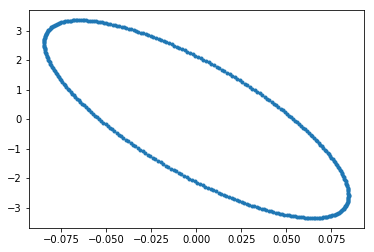

CPU times: user 327 ms, sys: 609 ms, total: 936 ms
Wall time: 286 ms


In [39]:
%%time
tofwidths = use_covmat.tofwidths(P=10, M=8)
beamdivs = use_covmat.beamdivs(theta=0.01, phi=0.01)
samplethickness = 0.001
# ellipsoid_trace, mR, lambdas = use_covmat.compute(
cm_res = compute(
    sampleyml, Ei, dynamics, scan,
    instrument, pixel,
    tofwidths, beamdivs, samplethickness,
    plot=True)
ellipsoid_trace = cm_res['u']

# Use Res Comps

In [12]:
!mcvine-neutron-storage-count-neutrons /SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons

240459


In [13]:
rm -rf out.res_comps_tmp/

In [14]:
beam = "/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9"
psi_axis = scan
use_res_comps.setup(
    'out.res_comps_tmp', sampleyml, beam, dynamics.E, dynamics.hkl0, dynamics.hkl_dir,
    psi_axis, instrument, pixel)

Ei=126.211753632, t0=16.0728240277
Computed:
* psi=3.60648578622 degree
* Q=[  5.89597548e+00  -7.31456748e+00  -6.69857149e-16]
* hkl2Qmat=[[ -7.18145613e-01   8.90933920e-01   8.15903957e-17]
 [  6.29985417e-01   5.07805633e-01  -8.09165116e-01]
 [ -6.29985417e-01  -5.07805633e-01  -8.09165116e-01]]
* ki=7.80444915794
* vectors ki=[ 7.80444916  0.          0.        ], kf=[  1.90847368e+00   7.31456748e+00   6.69857149e-16]
These two numbers should be very close:
  7.8
  7.8
  Ei=126.211753632, Ef=118.411753632
* Ef=118.411753632
* pixel positon=[  7.57386687e-01   2.90282025e+00   2.65835936e-16]
* pixel_position=[  7.57386687e-01   2.90282025e+00   2.65835936e-16]
t_m2s=0.00278375914959, t_s2p=0.000630306387723, t_m2p=0.00341406553731


In [15]:
ls out.res_comps_tmp/

run.py  sample/


In [16]:
cat out.res_comps_tmp/run.py

#!/usr/bin/env python
import mcvine.cli
from numpy import array
from mcvine_workflow.singlextal.resolution import use_res_comps as urc
beam_neutrons_path = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons'
instrument = urc.instrument('ARCS', '3.*meter', '13.6*meter', '-0.15*meter')
samplexmlpath = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/7-check-bad-points-1/out.res_comps_tmp/sample/sampleassembly.xml'
psi = 0.06294505139597527
hkl2Q = array([[ -7.18145613e-01,   8.90933920e-01,   8.15903957e-17],
       [  6.29985417e-01,   5.07805633e-01,  -8.09165116e-01],
       [ -6.29985417e-01,  -5.07805633e-01,  -8.09165116e-01]])
pp = array([  7.57386687e-01,   2.90282025e+00,   2.65835936e-16])
pixel = urc.pixel('0.5*inch', 'meter/128', '10*atm', position=(pp[1], pp[2], pp[0]))
t_m2p = 0.0034140655373103394
Q = array([  5.89597548e+00,  -7.31456748e+00,  -6.69857149e-16])
E = 7.8
hkl_projection = array([ 1.,  0.,  0.

In [17]:
%%time
%cd {workdir}/out.res_comps_tmp/
!python run.py >log.run
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/7-check-bad-points-1/out.res_comps_tmp
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")
/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/7-check-bad-points-1
CPU times: user 536 ms, sys: 203 ms, total: 739 ms
Wall time: 27.5 s


In [18]:
ls out.res_comps_tmp/

dEs.npy  dhkls.npy  dxs.npy  log.run  probs.npy  res.h5  run.py  sample/


## Get mcvine-simulated data

In [24]:
dhkls = np.load('out.res_comps_tmp/dhkls.npy')
dEs = np.load('out.res_comps_tmp/dEs.npy')
probs = np.load('out.res_comps_tmp/probs.npy')

In [25]:
dhs,dks,dls = dhkls.T

## get slice of resolution 

In [26]:
mask=(dls<0.02)*(dls>-0.02)*(dks<0.02)*(dks>-0.02)

hist, qedges, Eedges = np.histogram2d(
    x=dhs[mask], y=dEs[mask], bins=(np.arange(-1, 1, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])

qaxis = H.axis('q', boundaries=qedges)
Eaxis = H.axis('E', boundaries=Eedges)
IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)

plot z in (0.0, 0.0888375862735)


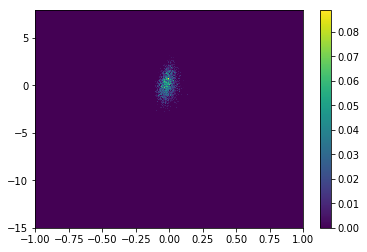

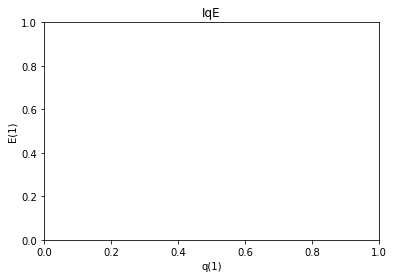

In [27]:
H.plot(IqE)

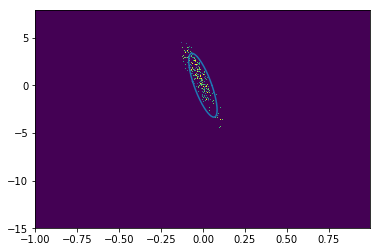

In [40]:
qgrid, Egrid = np.mgrid[
    IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
    IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
]
plt.pcolormesh(qgrid, Egrid, IqE.I)
plt.clim(0, 1e-2)
plt.plot(ellipsoid_trace[:,0], ellipsoid_trace[:,1])

# Plot along xyz directions

In [43]:
%%time
"""
tofwidths = use_covmat.tofwidths(P=10, M=2)
beamdivs = use_covmat.beamdivs(theta=0.05, phi=0.05)
samplethickness = 0.0001
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "11.7*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )
"""
unit_vectors = [[1,0,0], [0,1,0], [0,0,1]]
axes = 'hkl'

traces = []
IqEs = []
for axis_index, uv in enumerate(unit_vectors):
    dynamics.hkl_dir = np.array(uv)
    # ellipsoid_trace, mR, lambdas = use_covmat.compute(
    cm_res = compute(
        sampleyml, Ei, dynamics, scan,
        instrument, pixel,
        tofwidths, beamdivs, samplethickness,
        plot=False)
    ellipsoid_trace = cm_res['u']
    traces.append(ellipsoid_trace)
    
    mask = True
    for axis_index2, axis in enumerate(axes):
        if axis_index2==axis_index: continue # skip the axis of interest
        # print "d%ss<0.02"%axis, "d%ss>-0.02"%axis
        mask *= eval("d%ss<0.002"%axis)*eval("d%ss>-0.002"%axis)
        continue
    # print mask.shape, mask.sum(), mask.dtype
    dqs = eval("d%ss" % axes[axis_index])
    hist, qedges, Eedges = np.histogram2d(
        x=dqs[mask], y=dEs[mask], bins=(np.arange(-1, 1, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])
    # hist, qedges, Eedges = np.histogram2d(
    #    x=dqs, y=dEs, bins=(np.arange(-0.2, 0.2, 0.002), np.arange(-15,8,0.1)), weights=probs)
    qaxis = H.axis('q', boundaries=qedges)
    Eaxis = H.axis('E', boundaries=Eedges)
    # print hist.sum()
    IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)
    IqEs.append(IqE)
    continue

XXXXXXXXXXXXXXXXXXXXXXX
126 [-8.21  0.    0.  ] 7.8 -5 90.0
psi=3.6452879739, Q=[  5.90092774e+00  -7.31057290e+00  -6.70223167e-16]
hkl2Q=array([[ -7.18748812e-01,   8.90447369e-01,   8.16349777e-17],
       [  6.29641373e-01,   5.08232159e-01,  -8.09165116e-01],
       [ -6.29641373e-01,  -5.08232159e-01,  -8.09165116e-01]])
(Q = hkl dot hkl2Q)
psi=3.6452879739 degree
psi=0.0636222773279 radian
9.39496803445
7.79789939468
[  1.89697165e+00   7.31057290e+00   6.70223167e-16]
ti= 2364.69322632
tf= 630.870727584
R= 3.0
Q= [  5.90092774e+00  -7.31057290e+00  -6.70223167e-16]
eeta= 1.31691230299
m,hbar,L_PM,ti,phii,mus= 1.675e-27 1.0545718e-34 11.61 2364.69322632 0 1e-06
pQz_pphii= 7.79823053697
J=
[[ -4.05876319e-04   3.20068990e-04   8.26677850e-02  -6.51907814e-02
   -6.73073855e-02   0.00000000e+00   7.78170114e-01  -0.00000000e+00
   -0.00000000e+00]
 [ -2.11424361e-04   1.23348585e-03   4.30623390e-02  -2.51233043e-01
   -2.59390038e-01   0.00000000e+00  -2.01922157e-01   8.30043328

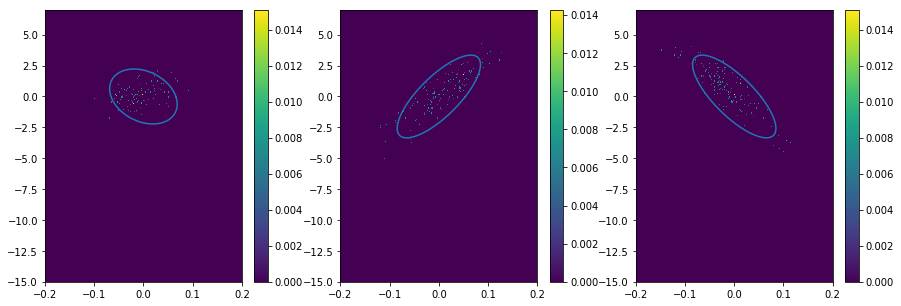

In [44]:
plt.figure(figsize=(15, 5))
for i, (trace, IqE) in enumerate(zip(traces, IqEs)):
    plt.subplot(1, 3, i+1)
    qgrid, Egrid = np.mgrid[
        IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
        IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
    ]
    plt.pcolormesh(qgrid, Egrid, IqE.I)
    #plt.clim(0, 1e-1)
    plt.colorbar()
    plt.plot(trace[:,0], trace[:,1])
    plt.xlim(-0.2, 0.2)
    plt.ylim(-15, 7)